In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dataset import *

#sys.path.insert(0, '/mnt/d/projects/bassline_transcription')
sys.path.insert(0, '/scratch/users/udemir15/ELEC491/bassline_transcription')

from utilities import *

# Read Metadata

In [2]:
directories = get_directories('../data/directories.json')

_, track_dicts, track_titles = read_metadata(directories, 'TechHouse_total_track_dicts.json')

In [3]:
with open('../data/metadata/bad_beat_f0_titles.txt', 'r') as infile:
    bad_titles = infile.read().split('\n')

## Analysis


Codebook before correction:
{0, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 100}

Codebook after correction:
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}

Filtered Codes:
[24, 25, 26, 27, 52, 53, 54, 55, 56, 57, 58, 59, 60]

624/10460 Tracks couldnt found!

581/10460 Tracks filtered out because of notes!

4318/10460 Tracks filtered out because of beat, f0 analysis!

Final Minor Dataset size: 4421
Final Major Dataset size: 516


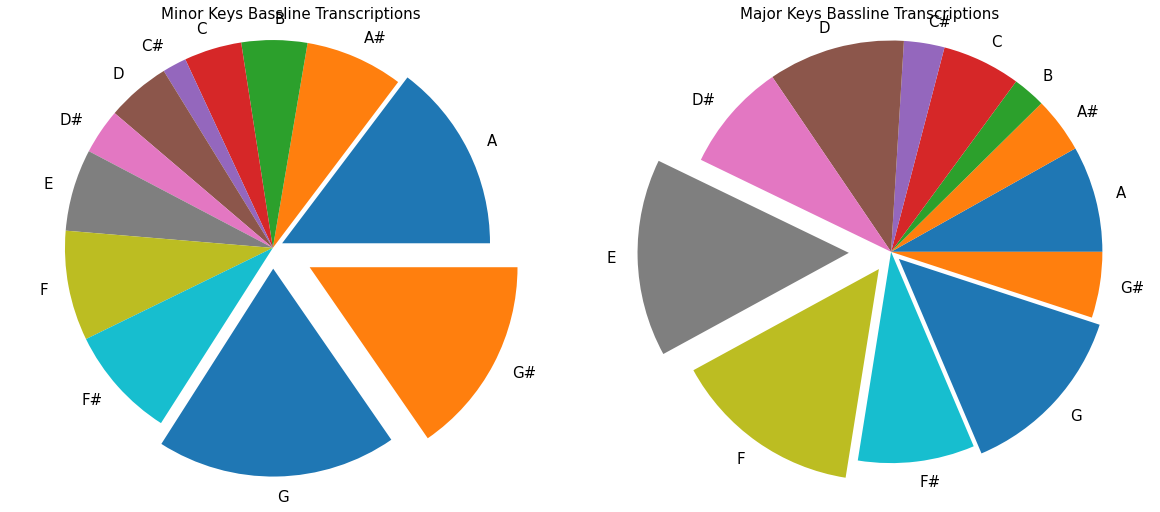

In [4]:
M=8
representation_path = os.path.join('..','data','datasets')
df_minor, df_major = create_dataframes(track_dicts, bad_titles, M, directories)

m_counter = count_keys(df_minor, track_dicts)
M_counter = count_keys(df_major, track_dicts)

key_pie_charts(m_counter, M_counter)

Original min: 35, max: 60
Transposed min: 24, max: 60


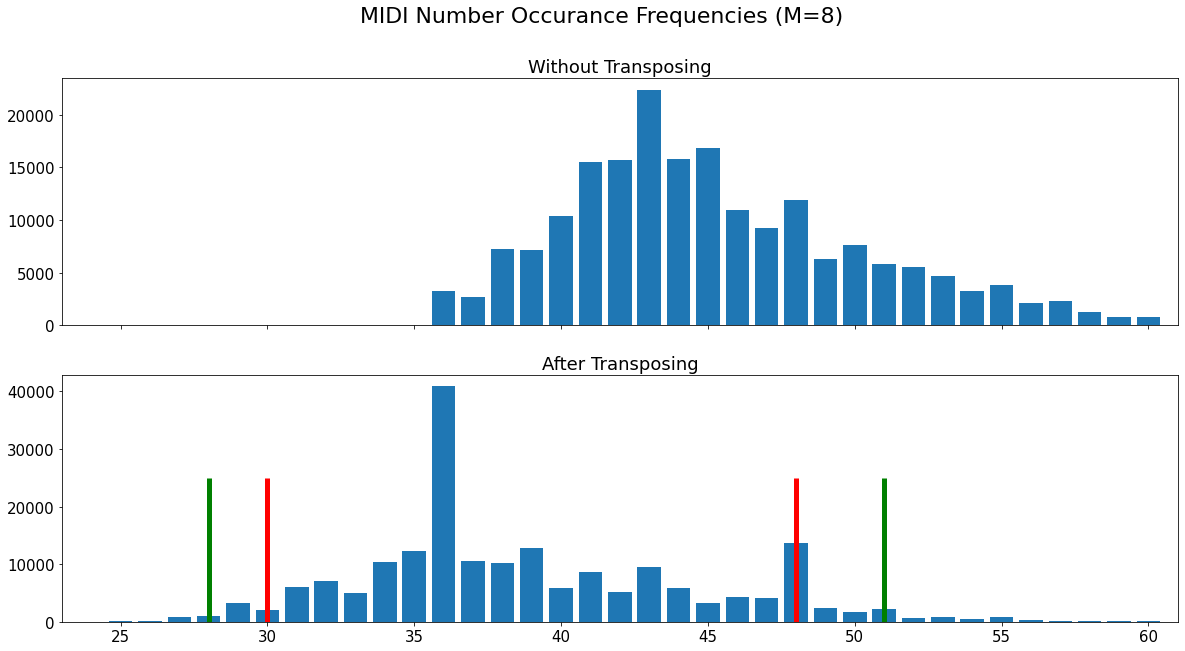

In [11]:
M=8
note_counter, note_counter_T = count_notes(track_dicts, directories, M)

plot_note_occurances(note_counter, note_counter_T, M)

dataset_name = 'TechHouse_bassline_representations'

representation_path = os.path.join('..','data','datasets','[28, 51]')

for M in [1, 2, 4, 8]:
    df_minor, df_major = create_dataframes(track_dicts, bad_titles, M, directories)

    min_title = dataset_name+'_min_M{}.csv'.format(M)
    min_dir = os.path.join(representation_path, min_title)
    df_minor.to_csv(min_dir, index=False, header=False)

    maj_title = dataset_name+'_maj_M{}.csv'.format(M)
    maj_dir = os.path.join(representation_path, maj_title)
    df_major.to_csv(maj_dir, index=False, header=False)

# Merging Track Dicts

In [ ]:
directories = get_directories('../data/directories.json')

track_dicts_name = 'traxsource_crawl_0_2500_track_dicts.json'
_, track_dicts0, track_titles0 = read_metadata(directories, track_dicts_name)

track_dicts_name = 'traxsource_crawl_2500_5000_track_dicts.json'
_, track_dicts1, track_titles1 = read_metadata(directories, track_dicts_name)

track_dicts_name = 'traxsource_crawl_5000_7500_track_dicts.json'
_, track_dicts2, track_titles2 = read_metadata(directories, track_dicts_name)

track_dicts_name = 'traxsource_crawl_7500_10000_track_dicts.json'
_, track_dicts3, track_titles3 = read_metadata(directories, track_dicts_name)

track_dicts_name = 'traxsource_crawl_10000_10898_track_dicts.json'
_, track_dicts4, track_titles4 = read_metadata(directories, track_dicts_name)

track_dicts_name = 'TechHouse_track_dicts.json'
_, track_dicts5, track_titles3 = read_metadata(directories, track_dicts_name)

track_dicts = merge_track_dicts(track_dicts0, track_dicts1, track_dicts2, track_dicts3, track_dicts4, track_dicts5)
track_titles = list(track_dicts.keys())

with open('../data/metadata/TechHouse_total_track_dicts.json', 'w') as outfile:
    json.dump(track_dicts, outfile, indent=4)